<a href="https://colab.research.google.com/github/gopal2812/mlblr/blob/master/tenserflowprobabilitymodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports and Global Variables (run this cell first)  { display-mode: "form" }
"""
The book uses a custom matplotlibrc file, which provides the unique styles for
matplotlib plots. If executing this book, and you wish to use the book's
styling, provided are two options:
    1. Overwrite your own matplotlibrc file with the rc-file provided in the
       book's styles/ dir. See http://matplotlib.org/users/customizing.html
    2. Also in the styles is  bmh_matplotlibrc.json file. This can be used to
       update the styles in only this notebook. Try running the following code:

        import json
        s = json.load(open("../styles/bmh_matplotlibrc.json"))
        matplotlib.rcParams.update(s)
"""
!pip3 install -q wget
from __future__ import absolute_import, division, print_function
#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

import numpy as np
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/))
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf
tfe = tf.contrib.eager

# Eager Execution
#@markdown Check the box below if you want to use [Eager Execution](https://www.tensorflow.org/guide/eager)
#@markdown Eager execution provides An intuitive interface, Easier debugging, and a control flow comparable to Numpy. You can read more about it on the [Google AI Blog](https://ai.googleblog.com/2017/10/eager-execution-imperative-define-by.html)
use_tf_eager = False #@param {type:"boolean"}

# Use try/except so we can easily re-execute the whole notebook.
if use_tf_eager:
    try:
        tf.enable_eager_execution()
    except:
        pass

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

  
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
        `namedtuple` or combinations thereof.

    Returns:
        ndarrays: Object with same structure as `tensors` except with `Tensor` or
          `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.contrib.framework.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.contrib.framework.is_tensor(t) else t
             for t in tf.contrib.framework.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=True):
    """
    Allowing the notebook to make use of GPUs if they're available.
    
    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear 
    algebra that optimizes TensorFlow computations.
    """
    config = tf.ConfigProto()
    config.log_device_placement = True
    if enable_gpu_ram_resizing:
        # `allow_growth=True` makes it possible to connect multiple colabs to your
        # GPU. Otherwise the colab malloc's all GPU ram.
        config.gpu_options.allow_growth = True
    if enable_xla:
        # Enable on XLA. https://www.tensorflow.org/performance/xla/.
        config.graph_options.optimizer_options.global_jit_level = (
            tf.OptimizerOptions.ON_1)
    return config


def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """
    if config is None:
        config = session_options()
    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

reset_sess()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Create a data set
Let's generate some data using our model of two lambda distributions, with a switchpoint in between them, tau. Assume we're looking at a period of 100 days. We'll generate a switchpoint from a uniform distribution between day 0 and 100. 

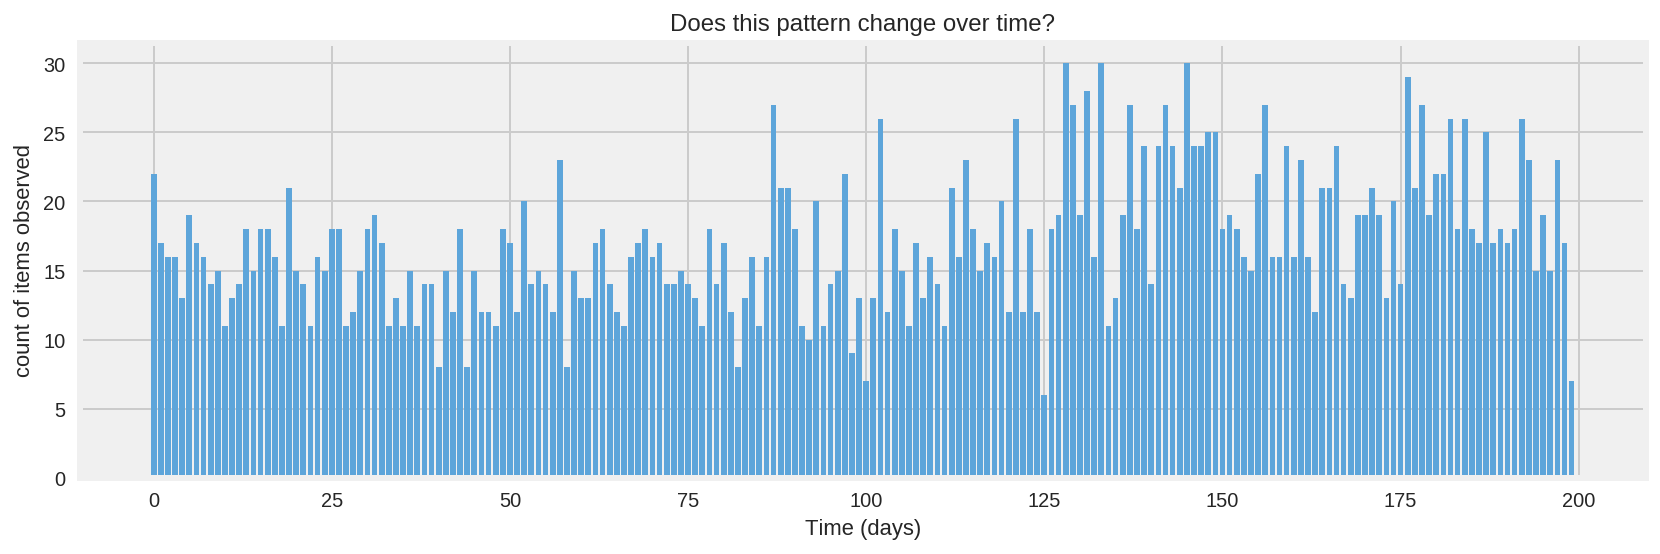

In [2]:

num_days = 200
days = tf.range(num_days)
true_lambda_1_ = 15
true_lambda_2_ = 20 #lets make this a tough one to figure out!
true_tau_ = 0.63

switchpoint = tf.cast(true_tau_ * num_days,tf.int32)

# Create model, build graph

# Create a distribution, assign to random variable
rv_observation_1 = tfd.Poisson(rate=true_lambda_1_)

#Gather n=switchpoint samples from this distribution
observation_1 = rv_observation_1.sample(switchpoint)

# Create a similar distribution, with a different rate
rv_observation_2 = tfd.Poisson(rate=true_lambda_2_)

# Now sample from the 2nd distribution, simulating that a switch in rate has taken place
# starting at day = switchpoint+1
observation_2 = rv_observation_2.sample(num_days-switchpoint)

# Concatenate these samples together
observations = tf.concat([observation_1,observation_2],0)

# Evaluate graph
[ 
    switchpoint_,
    observations_,
    days_
] =evaluate([
    switchpoint,
    observations,
    days
])

count_data = observations_ # to make the rest of the code compatible
n_count_data = len(count_data)

plt.figure(figsize=(12.5, 4))
plt.bar(days_, count_data, color="#5DA5DA")
plt.title ("Does this pattern change over time?")
plt.xlabel("Time (days)")
plt.ylabel("count of items observed")
plt.show()


# Define our probabilisti model

The joint_log_prob is where all the magic happens. See [Chapter 2 of Bayesian Methods for Hackers](https://https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_TFP.ipynb) for more info.

In [0]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
  
  alpha = np.array(1. / count_data.mean(), np.float32) # original alpha- prior for Poisson rates
  rv_lambda_1 = tfd.Exponential(rate=alpha) #original distribution for lambda_1
  rv_lambda_2 = tfd.Exponential(rate=alpha) #original distribution for lambda_2

  # Here's some other values you can try out, per the Exercises section below

  # change the alpha to be 0.5 * 1/mean
  #alpha = np.array(1. / count_data.mean()/2.0, np.float32)
  #rv_lambda_1 = tfd.LogNormal(loc=0.,scale=1.)
  #rv_lambda_2 = tfd.LogNormal(loc=0.,scale=1.)
  #rv_lambda_2 = log_normal

  # Create prior distribution
  rv_tau = tfd.Uniform()
  
  # Create conditional distribution to compute the likelihood of observed data 
  # given the current guess of parameters in the model, p(observed_data | model_parameters)

  # use either lambda_1 or lambda_2 rate value, depending on whether the day is before or after the 
  # guessed switchpoint value of tau
  lambda_ = tf.gather(
      [lambda_1, lambda_2],
      indices=tf.to_int32(tau * count_data.size <= np.arange(count_data.size)))
  rv_observation = tfd.Poisson(rate=lambda_)
  
  return (
      rv_lambda_1.log_prob(lambda_1)
      + rv_lambda_2.log_prob(lambda_2)
      + rv_tau.log_prob(tau)
      + tf.reduce_sum(rv_observation.log_prob(count_data))
  )

# Set up the HMC



In [4]:
burnin = int(1e3)
number_of_steps = int(10e3)

# start the HMC off with some reasonable values for lambda1, lambda2, tau
initial_chain_state = [
    count_data.mean() * tf.ones([], dtype=np.float32, name="init_lambda1"),
    count_data.mean() * tf.ones([], dtype=np.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=np.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R for lambda1
    tfp.bijectors.Exp(),       # Maps a positive real to R for lambda1
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R for tau
]


# Define a closure over our joint_log_prob. This closure has the effect of locking down the observed data,
# allowing the HMC to make educated guesses about the model parameters
def unnormalized_log_posterior(lambda1, lambda2, tau):
  return joint_log_prob(count_data, lambda1, lambda2, tau)

# Call the HMC with our closure function of joint_log_prob, to estimate model parameters
[
    posterior_lambda_1,
    posterior_lambda_2,
    posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
    num_results=int(number_of_steps),
    num_burnin_steps=int(burnin), # HMC gets rid of our burnin iterations automatically
    current_state=initial_chain_state,
    kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior, #here's our closure
            step_size=0.005,  # more data--> smaller step size
            num_leapfrog_steps=2),
        bijector=unconstraining_bijectors))



Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.


# Estimate the posterior probabilties of parameters, given data

In [5]:
# Execute the graph
  [
    posterior_lambda_1_,
    posterior_lambda_2_,
    posterior_tau_,
    kernel_results_,
  ] = evaluate([
    posterior_lambda_1,
    posterior_lambda_2,
    posterior_tau,
    kernel_results,
  ])
  
#above 0.7 is good
print("acceptance rate: {}".format(
    np.mean(kernel_results_.inner_results.is_accepted)))

acceptance rate: 0.845


# Check on HMC convergence

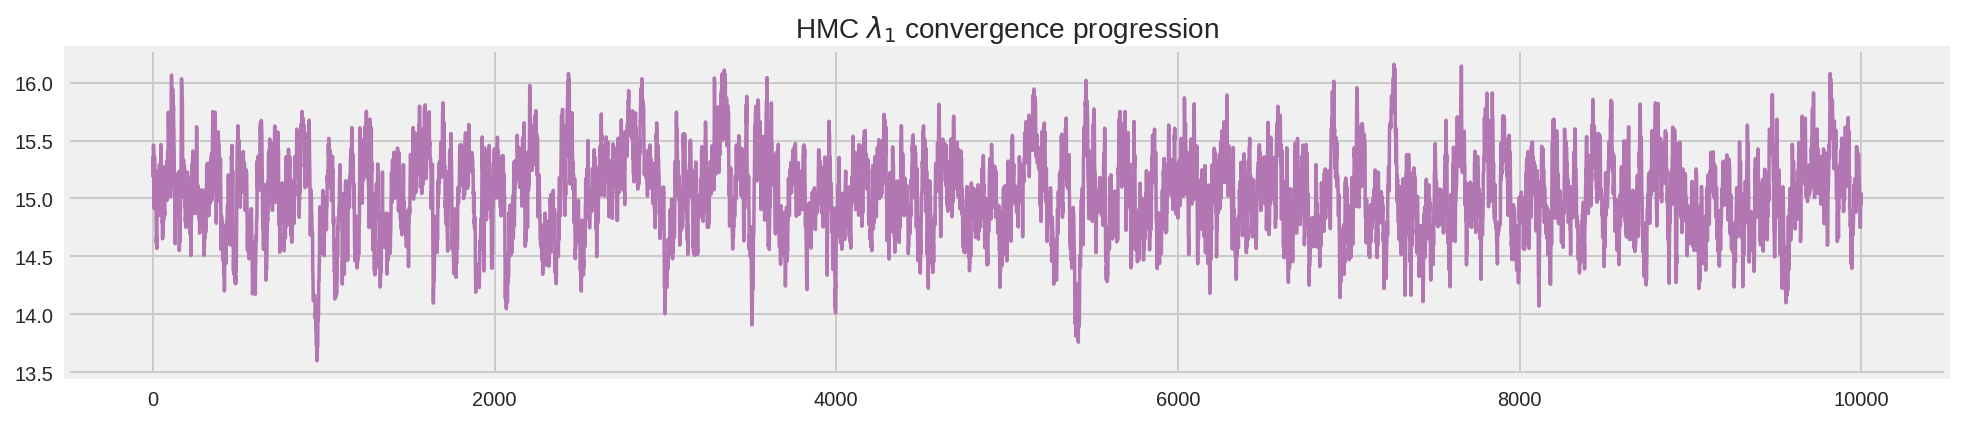

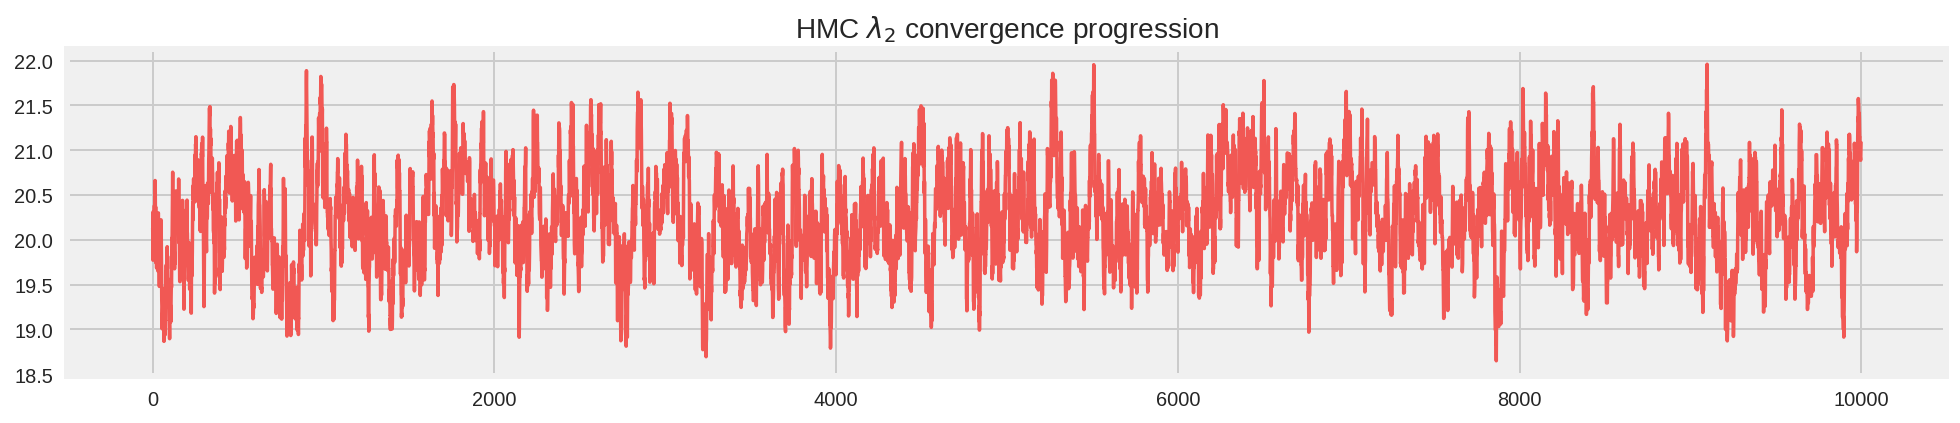

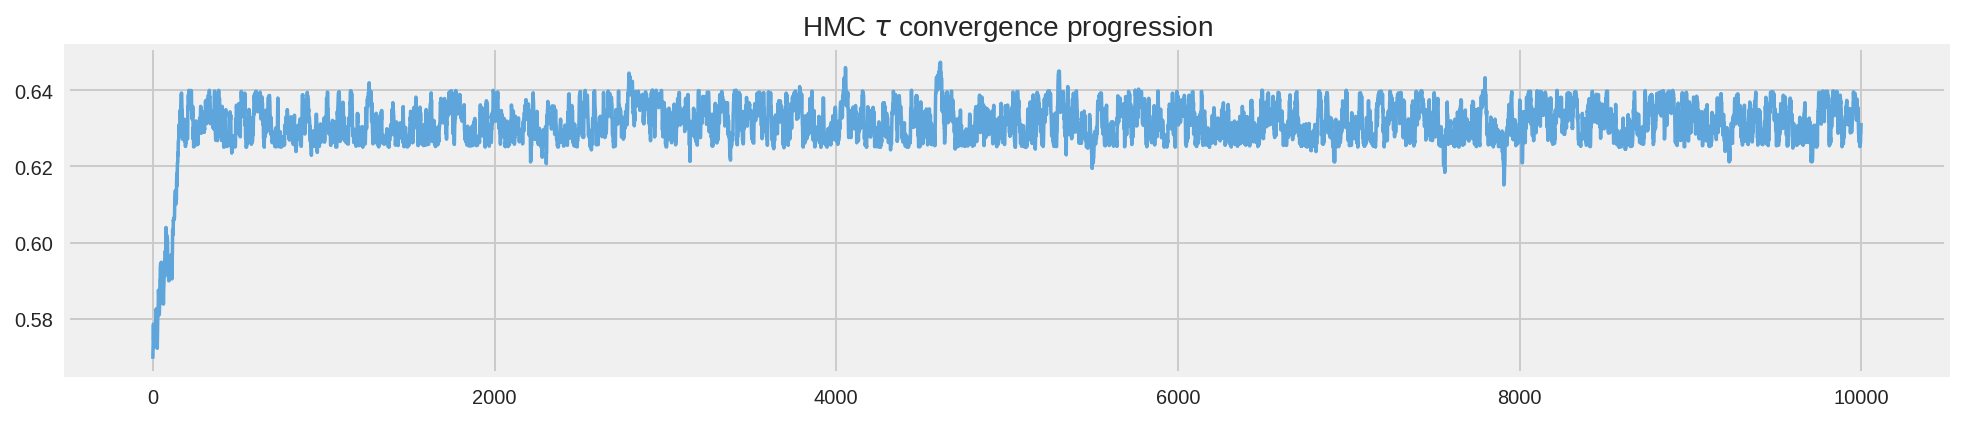

In [6]:
plt.figure(figsize=(15,3))
plt.plot(np.arange(number_of_steps), posterior_lambda_1_, color=TFColor[6])
plt.title('HMC $\lambda_1$ convergence progression', fontsize=14)

plt.figure(figsize=(15,3))
plt.plot(np.arange(number_of_steps), posterior_lambda_2_, color=TFColor[0])
plt.title('HMC $\lambda_2$ convergence progression', fontsize=14)

plt.figure(figsize=(15,3))
plt.plot(np.arange(number_of_steps), posterior_tau_, color=TFColor[3])
plt.title(r'HMC $\tau$ convergence progression', fontsize=14)
plt.show()

# Plot the posterior estimates of our model parameters

In [0]:
# Convert our samples to what the plotting code below expects.
lambda_1_samples = posterior_lambda_1_
lambda_2_samples = posterior_lambda_2_
tau_samples = np.array(np.floor(posterior_tau_ * count_data.size),
                       dtype=np.int32)

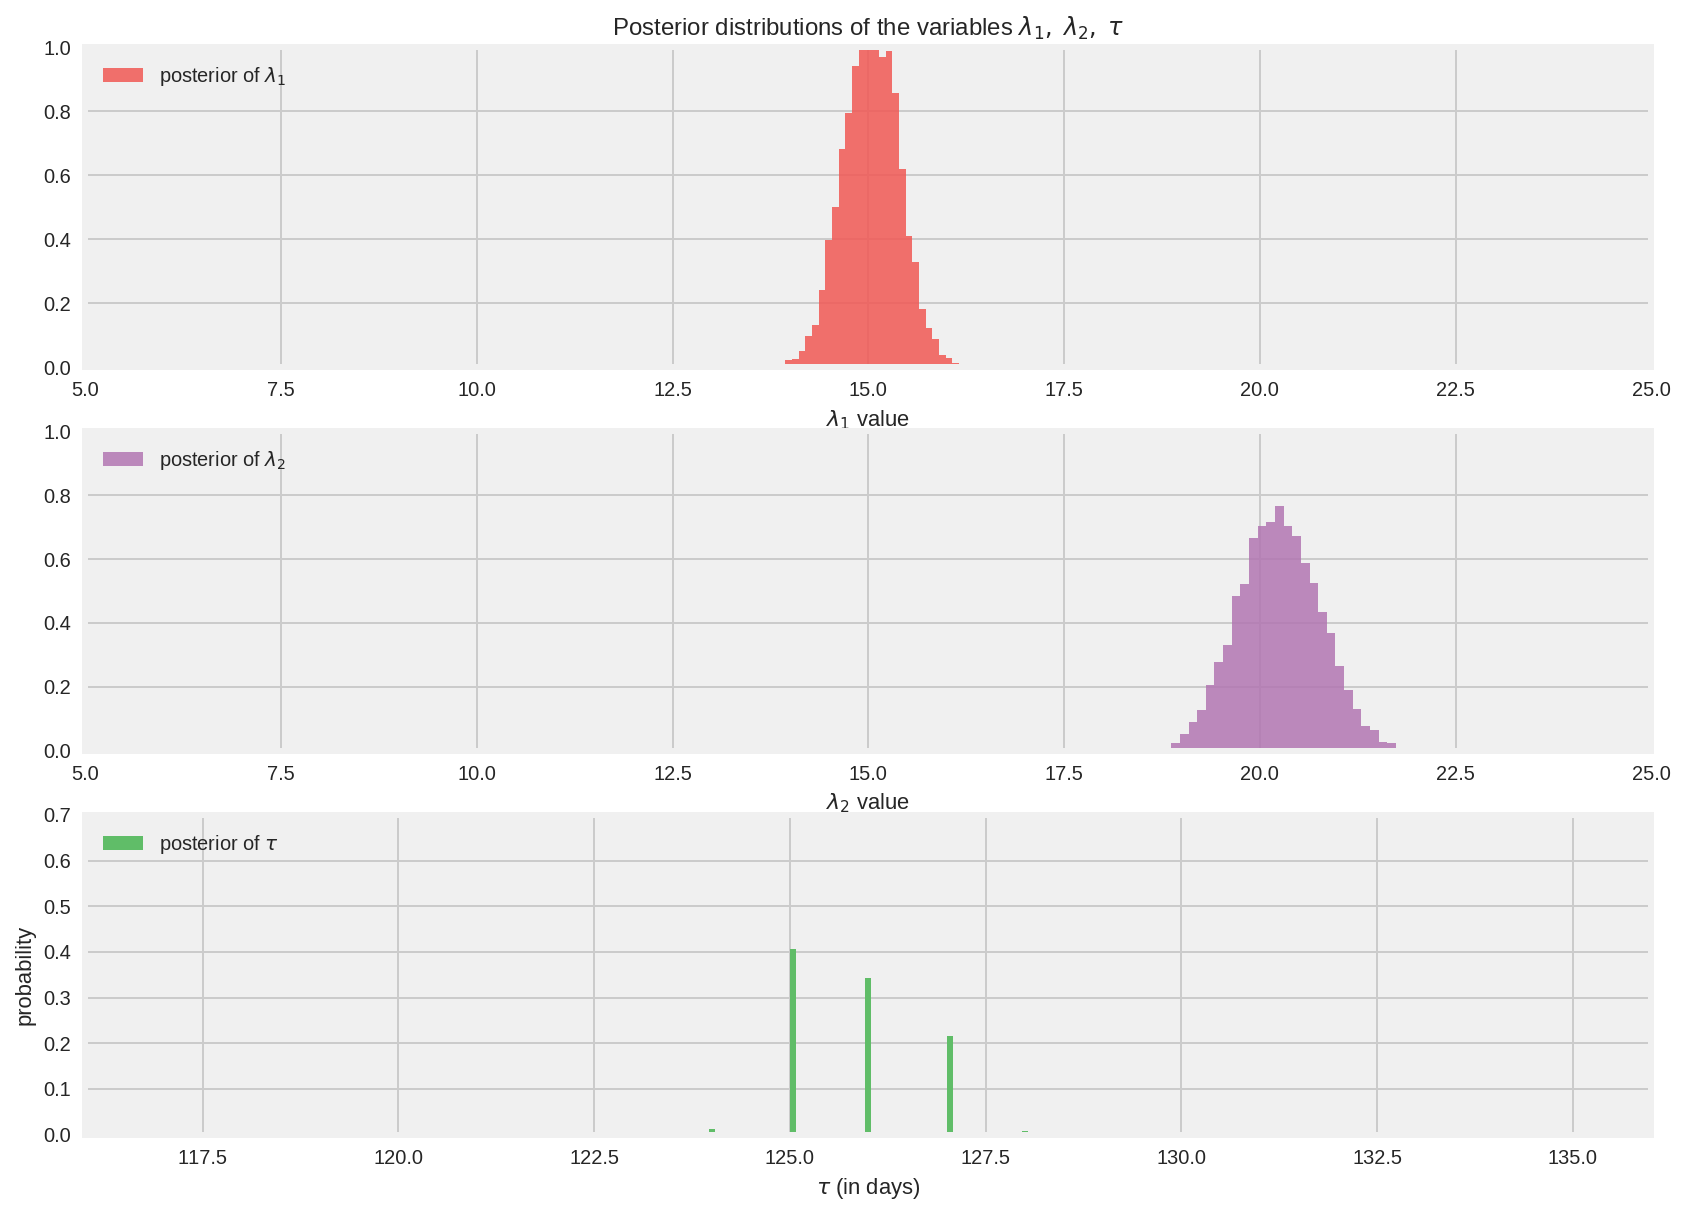

In [8]:

figsize(12.5, 10)

# Adapted from Bayesian Methods for Hackers, TFP version
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color=TFColor[0], density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([true_lambda_1_-10,true_lambda_1_+10])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
plt.xlim([true_lambda_1_-10,true_lambda_1_+10]) # so we can compare to lambda_1 distribution
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color=TFColor[2], weights=w, rwidth=2.)
#plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, 0.7])
plt.xlim([true_tau_ * num_days-10,true_tau_ * num_days+10]) 
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");
plt.show()


# Exercises

1.   Let's change the prior on the $\alpha$ parameter for our Exponential distributions.  Go the to the joint_log_prob function above, and change the alpha value from 1/mean to 0.5/mean, per the inline comments. Re-run the MCMC, do you get similar results? 
2.   How about a bigger change? What other distribution can we use instead of the Exponential for the $\alpha$ prior? How about a log-normal, [tfp.distributions.LogNormal](https://https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/LogNormal)? Try parameterizing with mean of 0 and standard deviation of 1, or be bold and try some other parameterization. 
3. Let's try out our own log-normal function, using a bijector. Run the code below, and then call the log_normal bijector from your joint_log_prob function. More info at [tf.contrib.distributions.TransformedDistribution](https://https://www.tensorflow.org/api_docs/python/tf/contrib/distributions/TransformedDistribution)








In [9]:
log_normal = tfd.TransformedDistribution(
  distribution=ds.Normal(loc=0., scale=1.),
  bijector=ds.bijectors.Inline(
    forward_fn=tf.exp,
    inverse_fn=tf.log,
    forward_min_event_ndims=0,
    inverse_log_det_jacobian_fn=(
      lambda y: -tf.reduce_sum(tf.log(y), axis=-1)),
  name="LogNormalTransformedDistribution"))

# try me, to see if the bijector works!
samples = log_normal.sample(10)
samples_ = evaluate(samples)
print (samples_)


NameError: ignored